In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torch.nn.modules.flatten import Flatten
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# device config (train our model on GPU if it is available which is much faster)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# These transforms will be performed on every datapoint - in this example we want to transform every
# datapoint to a Tensor datatype, and perform normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

# Notice how FashionMNIST is also built into PyTorch!
fashion_mnist_train = torchvision.datasets.FashionMNIST('', train=True, transform =transform, download=True)

# We will split out train dataset into train and validation!
fashion_mnist_train, fashion_mnist_val = torch.utils.data.random_split(fashion_mnist_train, [int(np.floor(len(fashion_mnist_train)*0.75)), int(np.ceil(len(fashion_mnist_train)*0.25))])

fashion_mnist_test = torchvision.datasets.FashionMNIST('', train=False, transform = transform, download=True)

Using downloaded and verified file: FashionMNIST/raw/train-images-idx3-ubyte.gz
Extracting FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/raw

Using downloaded and verified file: FashionMNIST/raw/train-labels-idx1-ubyte.gz
Extracting FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.58MB/s]


Extracting FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.27MB/s]

Extracting FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/raw



In [ ]:
# We will create DataLoaders just like before with a batch size of 100
batch_size = 100
dataloaders = {'train': DataLoader(fashion_mnist_train, batch_size=batch_size),
               'val': DataLoader(fashion_mnist_val, batch_size=batch_size),
               'test': DataLoader(fashion_mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(fashion_mnist_train),
                 'val': len(fashion_mnist_val),
                 'test': len(fashion_mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


In [ ]:
# plot a digit ground truth and autoencoding
def view_fashionmnist(label, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        for i, input in enumerate(inputs):
            # we only want to view a certain class
            if (labels[i] != label):
                continue
            # plot the ground truth
            ax = fig.add_subplot(1, count, idx)
            input = input.cpu().detach().numpy().reshape((28,28))
            ax.imshow(input, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

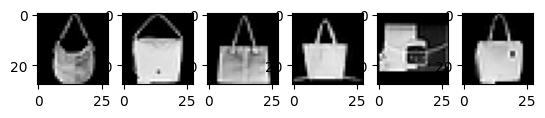

In [ ]:
# View 6 bags
view_fashionmnist(8, 6)

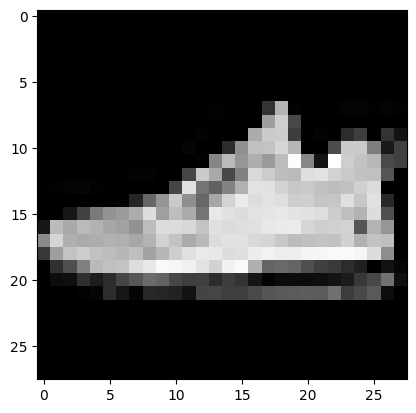

In [ ]:
# View 1 sneaker
view_fashionmnist(7, 1)

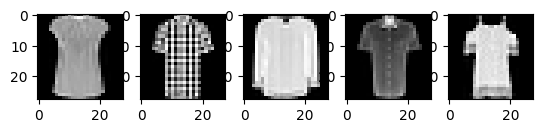

In [ ]:
# View 1 sneaker
view_fashionmnist(6, 5)

In [ ]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(SimpleAutoEncoder, self).__init__()
        # Split the Encoder and Decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256,32),
            nn.ReLU(),
            nn.Linear(32,256)
        )

        self.decoder = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)



In [ ]:
input_size = 784 # flattening our dataset 28*28 = 784
learning_rate = 0.001
num_epochs = 15

In [ ]:
model = SimpleAutoEncoder(input_size).to(device)
print(model)

SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
  )
)


In [ ]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_loss = np.inf
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data - for the autoencoder we don't care about the
            # labels, we are training the input against itself!
            for inputs, _ in dataloaders[phase]:
                # Important! We need to flatten every datapoint to be
                # compatible with our model!
                # print(inputs.shape)
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                # our targets are the same as our inputs!
                targets = inputs.to(device)
                # print(inputs.shape)
                # print(targets.shape)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(outputs.shape)
                    loss = criterion(outputs, targets)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # deep copy the model if it's the best loss
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves



In [ ]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model, training_curves = train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/15
----------
train Loss: 0.0629
val   Loss: 0.0606
test  Loss: 0.0604

Epoch 2/15
----------
train Loss: 0.0598
val   Loss: 0.0595
test  Loss: 0.0593

Epoch 3/15
----------
train Loss: 0.0587
val   Loss: 0.0587
test  Loss: 0.0585

Epoch 4/15
----------
train Loss: 0.0577
val   Loss: 0.0577
test  Loss: 0.0576

Epoch 5/15
----------
train Loss: 0.0569
val   Loss: 0.0569
test  Loss: 0.0567

Epoch 6/15
----------
train Loss: 0.0561
val   Loss: 0.0561
test  Loss: 0.0560

Epoch 7/15
----------
train Loss: 0.0554
val   Loss: 0.0557
test  Loss: 0.0556

Epoch 8/15
----------
train Loss: 0.0549
val   Loss: 0.0552
test  Loss: 0.0551

Epoch 9/15
----------
train Loss: 0.0544
val   Loss: 0.0547
test  Loss: 0.0546

Epoch 10/15
----------
train Loss: 0.0540
val   Loss: 0.0543
test  Loss: 0.0542

Epoch 11/15
----------
train Loss: 0.0536
val   Loss: 0.0540
test  Loss: 0.0539

Epoch 12/15
----------
train Loss: 0.0532
val   Loss: 0.0536
test  Loss: 0.0535

Epoch 13/15
----------
train Loss: 0

In [ ]:
# Utility functions for plotting your results!
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.view(inputs.shape[0],-1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    # class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])
    class_labels = np.unique(np.concatenate((preds, labels)))

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


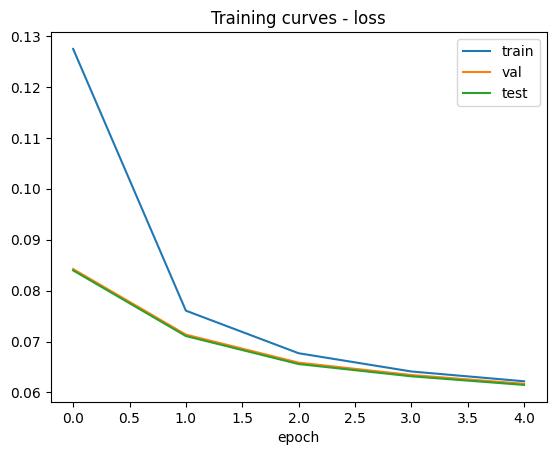

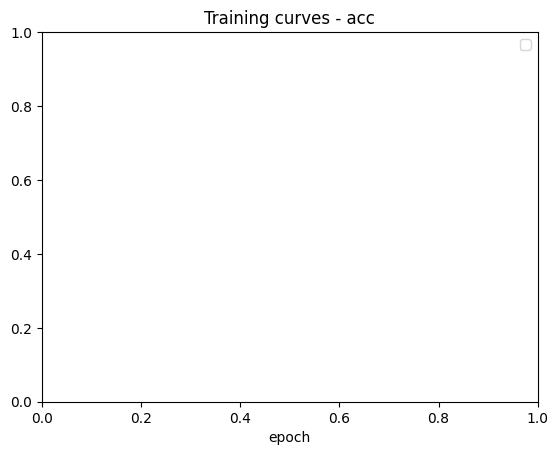

In [ ]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

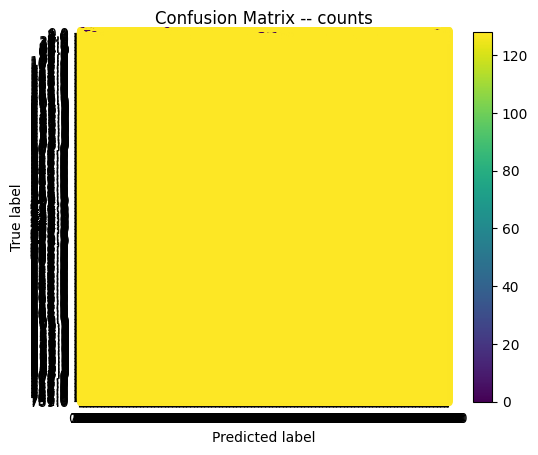

In [ ]:
res = plot_cm(model, device, dataloaders, phase='test')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

x = []
label = []
# random subset of test and grab x and y
# plot in matplotlib
for inputs, labels in dataloaders["test"]:
    inputs = inputs.view(inputs.shape[0],-1)
    inputs = inputs.to(device)
    for i, input in enumerate(inputs):
        encoding = model.encode(input)
        x.append(encoding.cpu().detach().numpy())
        label.append(labels[i])

def plot_dataset(x,y):
    print(len(x))
    print(len(y))
    x_np = np.array(x)
    # x_np.reshape(len(x), 2)
    encoding_size = x_np.shape[1]
    x_np = x_np.reshape(len(x), encoding_size)

    pca = PCA(n_components=2)
    x_np = pca.fit_transform(x_np)
    colors = []
    for label in y:
        if label == 0:
            colors.append("red")
        elif label == 1:
            colors.append("blue")
        elif label == 2:
            colors.append("beige")
        elif label == 3:
            colors.append("#c86558")
        elif label == 4:
            colors.append("#00b7c7")
        elif label == 5:
            colors.append("#0d88e6")
        elif label == 6:
            colors.append("#1a53ff")
        elif label == 7:
            colors.append("#5ad45a")
        elif label == 8:
            colors.append("#8be04e")
        elif label == 9:
            colors.append("#7eb0d5")
        else:
            colors.append("green")
    plt.scatter(x_np[...,0], x_np[...,1], color=colors)


10000
10000


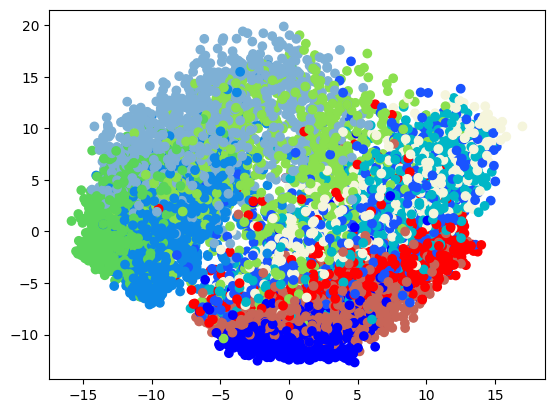

In [ ]:
plot_dataset(x,label)

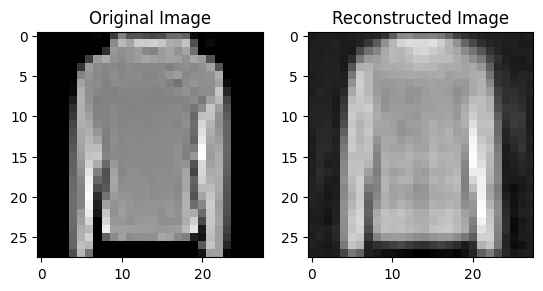

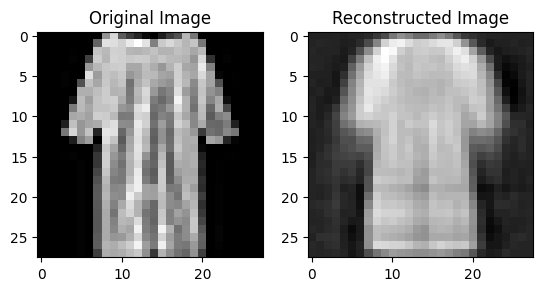

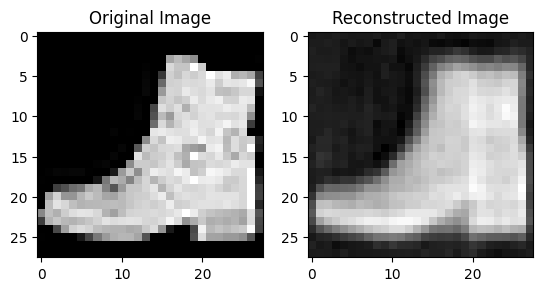

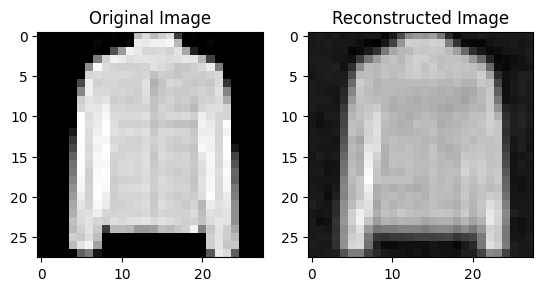

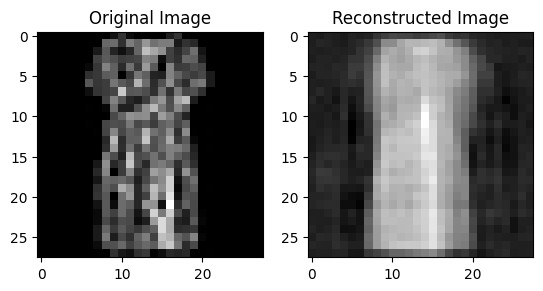

In [ ]:
import random
import matplotlib.pyplot as plt

# Assuming 'fashion_mnist_test' is your test dataset
num_images_to_test = 5
test_indices = random.sample(range(len(fashion_mnist_test)), num_images_to_test)
test_subset = Subset(fashion_mnist_test, test_indices)

test_loader = DataLoader(test_subset, batch_size=num_images_to_test, shuffle=False)

model.eval()  # Set the model to evaluation mode

for inputs, _ in test_loader:
    inputs = inputs.view(inputs.shape[0], -1).to(device)  # Flatten and move to device
    outputs = model(inputs)  # Get the reconstructed output
    # ... (Further processing and visualization)
    original_images = inputs.cpu().detach().numpy().reshape(num_images_to_test, 28, 28)
    reconstructed_images = outputs.cpu().detach().numpy().reshape(num_images_to_test, 28, 28)


    for i in range(num_images_to_test):
        plt.figure()
        plt.subplot(1, 2, 1)
        # Display the single image using imshow
        plt.imshow(original_images[i], cmap='gray')
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        # Display the single image using imshow
        plt.imshow(reconstructed_images[i], cmap='gray')
        plt.title('Reconstructed Image')

        plt.show()

In [28]:
from torch.nn.modules.flatten import Flatten
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # Split the Encoder and Decoder

        self.pipeline = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Linear(8*14*14, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.pipeline(x)

class CNNAutoEncoder(nn.Module):
    # A lot of these numbers (specifically the Linear layer at the end of the encoder
    # and the beginning of the decoder) are hardcoded for our 28x28 image size
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
        # Split the Encoder and Decoder

        self.encoder = nn.Sequential(
            # Perform a convolution on the input
            # in_channels = 1 because we have a grayscale image as input
            # The size of the Conv2d layer results in our output being resized
            # to (8, 28, 28).
            nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            # Perform a ReLU() just like on a linear layer
            nn.ReLU(),
            # MaxPool2d with this size will downsize our image to (8, 14, 14)
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            # Flatten the layer
            nn.Flatten(),
            # Perform a ReLU for nonlinearity
            nn.ReLU(),
            # One last Linear layer for our encoding of size 32 (just like the previous implementation)
            nn.Linear(8*14*14, 32),
        )

        self.decoder = nn.Sequential(
            # The input to our decoder will be a linear tensor of lenght 64
            nn.Linear(32, 8*14*14),
            # Perform a ReLU for nonlinearity
            nn.ReLU(),
            # Here we will Return to our unflattened size
            nn.Unflatten(dim = 1, unflattened_size = (8, 14, 14)),
            # Perform  a ReLU for nonlinearity
            nn.ReLU(),
            # ConvTranspose2d can be thought of as an "UnConvolution" which returns us to our original dimensions (1, 28, 28)
            nn.ConvTranspose2d(in_channels = 8, out_channels = 1, kernel_size = 2, stride = 2),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)

In [33]:
learning_rate = 0.001
num_epochs = 10

model_cnn = CNNClassifier().to(device)
print(model_cnn)

CNNClassifier(
  (pipeline): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=1568, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [24]:
# From https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_classification_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ['train', 'val', 'test']

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
        training_curves[phase+'_acc'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # No need to flatten the inputs!
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)
            training_curves[phase+'_acc'].append(epoch_acc)

            print(f'{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it's the best accuracy (bas
            if phase == 'val' and epoch_acc > best_acc:
              best_epoch = epoch
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves



In [35]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss for classification!
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# Train the model. We also will store the results of training to visualize
model_cnn, training_curves = train_classification_model(model_cnn, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.4705 Acc: 0.8311
val   Loss: 0.3975 Acc: 0.8605
test  Loss: 0.4241 Acc: 0.8491

Epoch 2/10
----------
train Loss: 0.3666 Acc: 0.8705
val   Loss: 0.3345 Acc: 0.8821
test  Loss: 0.3596 Acc: 0.8736

Epoch 3/10
----------
train Loss: 0.3258 Acc: 0.8846
val   Loss: 0.3118 Acc: 0.8889
test  Loss: 0.3361 Acc: 0.8789

Epoch 4/10
----------
train Loss: 0.2983 Acc: 0.8940
val   Loss: 0.2977 Acc: 0.8935
test  Loss: 0.3203 Acc: 0.8842

Epoch 5/10
----------
train Loss: 0.2772 Acc: 0.9010
val   Loss: 0.2881 Acc: 0.8988
test  Loss: 0.3097 Acc: 0.8872

Epoch 6/10
----------
train Loss: 0.2602 Acc: 0.9064
val   Loss: 0.2831 Acc: 0.8993
test  Loss: 0.3038 Acc: 0.8884

Epoch 7/10
----------
train Loss: 0.2463 Acc: 0.9120
val   Loss: 0.2792 Acc: 0.9007
test  Loss: 0.2997 Acc: 0.8894

Epoch 8/10
----------
train Loss: 0.2346 Acc: 0.9163
val   Loss: 0.2760 Acc: 0.9033
test  Loss: 0.2957 Acc: 0.8932

Epoch 9/10
----------
train Loss: 0.2241 Acc: 0.9204
val   Loss: 0.2739

In [37]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss','acc']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                if metric == 'acc':
                    plt.plot(epochs, [item.detach().cpu() for item in training_curves[key]])
                else:
                    plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

def classify_predictions(model, device, dataloader):
    model.eval()   # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs),dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:,1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return all_preds.detach().cpu(), all_labels.detach().cpu(), all_scores.detach().cpu()

def plot_cm(model, device, dataloaders, phase='test'):
    class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    ax = disp.plot().ax_
    ax.set_title('Confusion Matrix -- counts')


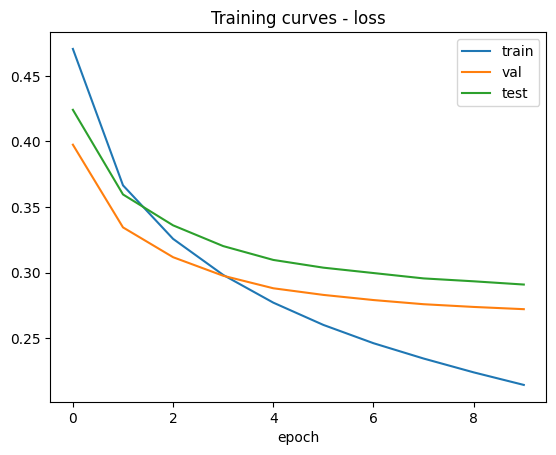

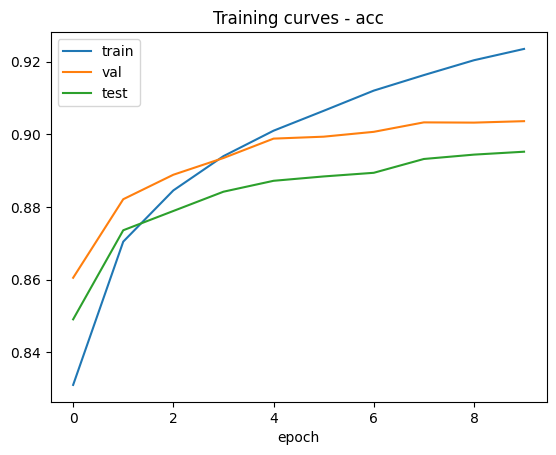

In [40]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

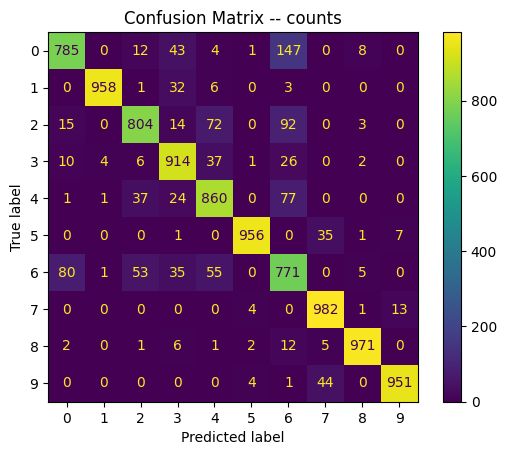

In [39]:
res = plot_cm(model_cnn, device, dataloaders, phase='test')